## ERA5

In [1]:
!pip install earthengine-api geemap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import pandas as pd

In [3]:
# Authenticate with Google Earth Engine
ee.Authenticate()
ee.Initialize(project='heat-index-472312')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [4]:
station_name = "NAIA"   # Example, replace with your station
station_coords = [121.004751, 14.5047]  # [longitude, latitude] of your station
buffer_km = 25

In [5]:
station_geom = ee.Geometry.Point(station_coords).buffer(buffer_km * 1000)
print(f"Station: {station_name}, Geometry created")

Station: NAIA, Geometry created


In [6]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
  .filterDate('2014-01-01', '2024-01-01')

In [7]:
print("Available Bands:", dataset.first().bandNames().getInfo())
print("Dataset size:", dataset.size().getInfo())

Available Bands: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum', 'evaporation_from_bare_soil_sum', 'evaporation_from_open_water_surfaces_excludi

In [8]:
naia = ee.Geometry.Point([121.004751, 14.5047]).buffer(25000)  # [longitude, latitude]
print(naia.getInfo())

def extract(img):
    vals = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=station_geom,
        scale=11132,  # ~11km resolution
        maxPixels=1e13,
        bestEffort=True
    )
    date_val = img.date().format("YYYY-MM-dd")
    feature = ee.Feature(None, vals).set("date", date_val)
    return feature

fc = dataset.map(extract)

{'type': 'Polygon', 'coordinates': [[[121.00475100000004, 14.72967164878704], [120.93978098034466, 14.720708810688375], [120.87999746192007, 14.694535845989524], [120.8301693916674, 14.653241774956648], [120.79426535760919, 14.600121008406933], [120.77513701616871, 14.539408775659826], [120.77429413569686, 14.475941867997484], [120.79178848130913, 14.414772371307949], [120.82621448010381, 14.360765514003141], [120.87482511899502, 14.318213622073776], [120.93375263089649, 14.290496512912886], [120.998315817062, 14.27981471877683], [121.0633897420274, 14.287016088123819], [121.12380927730423, 14.311529037631844], [121.17477570496655, 14.351407547122625], [121.21223538910895, 14.40348446574059], [121.23320138748883, 14.463621404974985], [121.23599275368507, 14.527035998433727], [121.22037204488855, 14.588681145824987], [121.18756897232193, 14.643646512117229], [121.14018683577443, 14.687550421705458], [121.08199781157474, 14.71689064706157], [121.01764255877491, 14.72932554281073], [121.0

In [9]:
print("Feature collection size:", fc.size().getInfo())
sample = fc.limit(5).getInfo()
print("Sample features:", sample['features'][0]['properties'])

Feature collection size: 3652
Sample features: {'date': '2014-01-01', 'dewpoint_temperature_2m': 293.1706520272424, 'dewpoint_temperature_2m_max': 294.5518358454085, 'dewpoint_temperature_2m_min': 292.2706391042156, 'evaporation_from_bare_soil_max': -2.9090174547072213e-06, 'evaporation_from_bare_soil_min': -0.0003925594854367416, 'evaporation_from_bare_soil_sum': -0.002656979183442173, 'evaporation_from_open_water_surfaces_excluding_oceans_max': -2.014091579216633e-06, 'evaporation_from_open_water_surfaces_excluding_oceans_min': -8.480842787709632e-05, 'evaporation_from_open_water_surfaces_excluding_oceans_sum': -0.0006559343511884493, 'evaporation_from_the_top_of_canopy_max': 8.301201005904288e-07, 'evaporation_from_the_top_of_canopy_min': -2.1803654531498307e-05, 'evaporation_from_the_top_of_canopy_sum': -2.7605242740189478e-05, 'evaporation_from_vegetation_transpiration_max': -7.33578140192619e-06, 'evaporation_from_vegetation_transpiration_min': -3.449795784482533e-05, 'evaporatio

In [10]:
dates = fc.aggregate_array("date").getInfo()
var_names = dataset.first().bandNames().getInfo()

In [11]:
data = {}
for v in var_names:
    try:
        values = fc.aggregate_array(v).getInfo()
        data[v] = values
        print(f"Extracted {len([x for x in values if x is not None])} non-null values for {v}")
    except Exception as e:
        print(f"Error extracting {v}: {e}")
        data[v] = [None] * len(dates)

# Create DataFrame
df = pd.DataFrame({"date": dates})

Extracted 3652 non-null values for dewpoint_temperature_2m
Extracted 3652 non-null values for temperature_2m
Extracted 3652 non-null values for skin_temperature
Extracted 3652 non-null values for soil_temperature_level_1
Extracted 3652 non-null values for soil_temperature_level_2
Extracted 3652 non-null values for soil_temperature_level_3
Extracted 3652 non-null values for soil_temperature_level_4
Extracted 3652 non-null values for lake_bottom_temperature
Extracted 3652 non-null values for lake_ice_depth
Extracted 3652 non-null values for lake_ice_temperature


Extracted 3652 non-null values for lake_mix_layer_depth


Extracted 3652 non-null values for lake_mix_layer_temperature


Extracted 3652 non-null values for lake_shape_factor
Extracted 3652 non-null values for lake_total_layer_temperature
Extracted 3652 non-null values for snow_albedo
Extracted 3652 non-null values for snow_cover
Extracted 3652 non-null values for snow_density
Extracted 3652 non-null values for snow_depth
Extracted 3652 non-null values for snow_depth_water_equivalent
Extracted 3652 non-null values for snowfall_sum
Extracted 3652 non-null values for snowmelt_sum
Extracted 3652 non-null values for temperature_of_snow_layer
Extracted 3652 non-null values for skin_reservoir_content
Extracted 3652 non-null values for volumetric_soil_water_layer_1
Extracted 3652 non-null values for volumetric_soil_water_layer_2
Extracted 3652 non-null values for volumetric_soil_water_layer_3
Extracted 3652 non-null values for volumetric_soil_water_layer_4
Extracted 3652 non-null values for forecast_albedo
Extracted 3652 non-null values for surface_latent_heat_flux_sum
Extracted 3652 non-null values for surface_

Extracted 3652 non-null values for runoff_sum
Extracted 3652 non-null values for snow_evaporation_sum
Extracted 3652 non-null values for sub_surface_runoff_sum
Extracted 3652 non-null values for surface_runoff_sum
Extracted 3652 non-null values for total_evaporation_sum
Extracted 3652 non-null values for u_component_of_wind_10m
Extracted 3652 non-null values for v_component_of_wind_10m
Extracted 3652 non-null values for surface_pressure
Extracted 3652 non-null values for total_precipitation_sum
Extracted 3652 non-null values for leaf_area_index_high_vegetation
Extracted 3652 non-null values for leaf_area_index_low_vegetation
Extracted 3652 non-null values for dewpoint_temperature_2m_min
Extracted 3652 non-null values for dewpoint_temperature_2m_max
Extracted 3652 non-null values for temperature_2m_min


Extracted 3652 non-null values for temperature_2m_max
Extracted 3652 non-null values for skin_temperature_min
Extracted 3652 non-null values for skin_temperature_max
Extracted 3652 non-null values for soil_temperature_level_1_min
Extracted 3652 non-null values for soil_temperature_level_1_max
Extracted 3652 non-null values for soil_temperature_level_2_min
Extracted 3652 non-null values for soil_temperature_level_2_max
Extracted 3652 non-null values for soil_temperature_level_3_min
Extracted 3652 non-null values for soil_temperature_level_3_max
Extracted 3652 non-null values for soil_temperature_level_4_min
Extracted 3652 non-null values for soil_temperature_level_4_max
Extracted 3652 non-null values for lake_bottom_temperature_min
Extracted 3652 non-null values for lake_bottom_temperature_max
Extracted 3652 non-null values for lake_ice_depth_min
Extracted 3652 non-null values for lake_ice_depth_max
Extracted 3652 non-null values for lake_ice_temperature_min
Extracted 3652 non-null valu

Extracted 3652 non-null values for lake_mix_layer_depth_max
Extracted 3652 non-null values for lake_mix_layer_temperature_min
Extracted 3652 non-null values for lake_mix_layer_temperature_max
Extracted 3652 non-null values for lake_shape_factor_min
Extracted 3652 non-null values for lake_shape_factor_max
Extracted 3652 non-null values for lake_total_layer_temperature_min
Extracted 3652 non-null values for lake_total_layer_temperature_max
Extracted 3652 non-null values for snow_albedo_min
Extracted 3652 non-null values for snow_albedo_max


Extracted 3652 non-null values for snow_cover_min
Extracted 3652 non-null values for snow_cover_max
Extracted 3652 non-null values for snow_density_min
Extracted 3652 non-null values for snow_density_max
Extracted 3652 non-null values for snow_depth_min
Extracted 3652 non-null values for snow_depth_max
Extracted 3652 non-null values for snow_depth_water_equivalent_min
Extracted 3652 non-null values for snow_depth_water_equivalent_max
Extracted 3652 non-null values for snowfall_min
Extracted 3652 non-null values for snowfall_max
Extracted 3652 non-null values for snowmelt_min
Extracted 3652 non-null values for snowmelt_max
Extracted 3652 non-null values for temperature_of_snow_layer_min
Extracted 3652 non-null values for temperature_of_snow_layer_max
Extracted 3652 non-null values for skin_reservoir_content_min
Extracted 3652 non-null values for skin_reservoir_content_max
Extracted 3652 non-null values for volumetric_soil_water_layer_1_min
Extracted 3652 non-null values for volumetric_s

In [12]:
for v in var_names:
    if v in data:
        df[v] = data[v]
        null_count = df[v].isnull().sum()
        print(f"Column {v}: {len(df[v]) - null_count} valid values, {null_count} null values")

print("\nDataFrame shape:", df.shape)
print("DataFrame info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Column dewpoint_temperature_2m: 3652 valid values, 0 null values
Column temperature_2m: 3652 valid values, 0 null values
Column skin_temperature: 3652 valid values, 0 null values
Column soil_temperature_level_1: 3652 valid values, 0 null values
Column soil_temperature_level_2: 3652 valid values, 0 null values
Column soil_temperature_level_3: 3652 valid values, 0 null values
Column soil_temperature_level_4: 3652 valid values, 0 null values
Column lake_bottom_temperature: 3652 valid values, 0 null values
Column lake_ice_depth: 3652 valid values, 0 null values
Column lake_ice_temperature: 3652 valid values, 0 null values
Column lake_mix_layer_depth: 3652 valid values, 0 null values
Column lake_mix_layer_temperature: 3652 valid values, 0 null values
Column lake_shape_factor: 3652 valid values, 0 null values
Column lake_total_layer_temperature: 3652 valid values, 0 null values
Column snow_albedo: 3652 valid values, 0 null values
Column snow_cover: 3652 valid values, 0 null values
Column sno

/tmp/ipython-input-905881357.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[v] = data[v]
/tmp/ipython-input-905881357.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[v] = data[v]
/tmp/ipython-input-905881357.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[v] = data[v]
/tmp/ipyth

In [13]:
metadata = []
for col in df.columns:
    if col == "date":
        continue

    # Skip if all values are null
    if df[col].isnull().all():
        print(f"Skipping {col} - all values are null")
        continue

    original_name = col
    original_unit = "varies"
    converted_unit = original_unit
    new_name = col

    # Kelvin → Celsius
    if "temperature" in col.lower():
        df[col] = df[col] - 273.15
        new_name = col + "_C"
        original_unit, converted_unit = "K", "°C"
    # Precipitation / Runoff / Evaporation (m → mm/day)
    elif col.endswith("_sum") or "precipitation" in col.lower() or "evaporation" in col.lower() or "runoff" in col.lower():
        df[col] = df[col] * 1000
        new_name = col + "_mm"
        original_unit, converted_unit = "m", "mm/day"
    # Pressure (Pa → hPa)
    elif "pressure" in col.lower():
        df[col] = df[col] / 100
        new_name = col + "_hPa"
        original_unit, converted_unit = "Pa", "hPa"
    # Wind (m/s → km/h)
    elif "u_component" in col.lower() or "v_component" in col.lower() or "wind" in col.lower():
        df[col] = df[col] * 3.6
        new_name = col + "_kmh"
        original_unit, converted_unit = "m/s", "km/h"
    # Snow depth (m → cm)
    elif "snow_depth" in col.lower():
        df[col] = df[col] * 100
        new_name = col + "_cm"
        original_unit, converted_unit = "m", "cm"
    # Radiation & Fluxes (J/m²/day → W/m²)
    elif col.endswith("_radiation_sum") or col.endswith("_flux_sum") or col.endswith("_heat_sum"):
        df[col] = df[col] / 86400
        new_name = col + "_Wm2"
        original_unit, converted_unit = "J/m²/day", "W/m²"

    # Rename column
    if new_name != col:
        df.rename(columns={col: new_name}, inplace=True)

    # Add metadata record
    metadata.append({
        "Band": original_name,
        "Converted Column": new_name,
        "Original Unit": original_unit,
        "Converted Unit": converted_unit
    })

In [14]:
meta_df = pd.DataFrame(metadata)
print("\nMetadata:")
print(meta_df)


Metadata:
                                    Band                     Converted Column  \
0                dewpoint_temperature_2m            dewpoint_temperature_2m_C   
1                         temperature_2m                     temperature_2m_C   
2                       skin_temperature                   skin_temperature_C   
3               soil_temperature_level_1           soil_temperature_level_1_C   
4               soil_temperature_level_2           soil_temperature_level_2_C   
..                                   ...                                  ...   
145              total_precipitation_max           total_precipitation_max_mm   
146  leaf_area_index_high_vegetation_min  leaf_area_index_high_vegetation_min   
147  leaf_area_index_high_vegetation_max  leaf_area_index_high_vegetation_max   
148   leaf_area_index_low_vegetation_min   leaf_area_index_low_vegetation_min   
149   leaf_area_index_low_vegetation_max   leaf_area_index_low_vegetation_max   

    Original Uni

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# FIXED: Updated filename to reflect correct location (NAIA)
filename = "ERA5-Land_Daily_Aggregated_'14_'23_NAIA.csv"
drive_path = f'/content/drive/MyDrive/ERA5_datasets/{filename}'

try:
    df.to_csv(drive_path, index=False)
    print(f"File saved to Google Drive: {filename}")
    print(f"Final DataFrame shape: {df.shape}")
except Exception as e:
    print(f"Error saving file: {e}")
    # Save locally as backup
    df.to_csv(filename, index=False)
    print(f"File saved locally: {filename}")


Mounted at /content/drive
File saved to Google Drive: ERA5-Land_Daily_Aggregated_'14_'23_NAIA.csv
Final DataFrame shape: (3652, 151)


## NDVI

In [9]:
import ee
import geemap
import pandas as pd

In [10]:
cloud_project = 'heat-index-472312'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Iba": ee.Geometry.Point([119.965661, 15.328408]).buffer(50000), # Longitude, Latitude
    "Infanta": ee.Geometry.Point([121.6490333, 14.74663611]).buffer(50000),
    "Laoag": ee.Geometry.Point([120.534723, 18.183016]).buffer(50000),
    "Legazpi": ee.Geometry.Point([123.728605, 13.150937]).buffer(50000),
    "NAIA": ee.Geometry.Point(([121.004751, 14.5047])).buffer(50000)
}

start_date = '2014-01-01'
end_date = '2024-01-01'

In [11]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract and process NDVI from VIIRS CDR dataset with scaling and interpolation.

    Dataset: NOAA/CDR/VIIRS/NDVI/V1
    Docs: https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_VIIRS_NDVI_V1
    Scale factor: 0.0001
    Valid range: -1 to 1
    Native resolution: ~5566m
    """

    viirs_ndvi = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").filterBounds(geometry).filterDate(start_date, end_date)

    print(f"Processing NDVI for {station_name}...")

    def extract_values(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

        ndvi = img.select('NDVI').multiply(0.0001)  # apply scale factor
        ndvi = ndvi.updateMask(ndvi.gte(-1).And(ndvi.lte(1)))

        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=5566,
            bestEffort=True,
            maxPixels=1e9
        )

        return ee.Feature(None, stats).set('date', date)

    # Map and convert
    features = viirs_ndvi.map(extract_values)
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No NDVI data for {station_name}")
        return df

    # Process timeseries
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range).reset_index().rename(columns={"index": "date"})

    g["NDVI_original"] = g["NDVI"]
    g["NDVI_linear"] = g["NDVI"].interpolate("linear", limit_direction="both")
    g["NDVI_spline"] = g["NDVI"].interpolate("spline", order=2, limit_direction="both")

    out_file = f"{station_name}_NDVI.csv"
    g[["date", "NDVI_original", "NDVI_linear", "NDVI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [12]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDVI for Iba...
Saved Iba_NDVI.csv (3653 rows)
Processing NDVI for Infanta...
Saved Infanta_NDVI.csv (3653 rows)
Processing NDVI for Laoag...
Saved Laoag_NDVI.csv (3653 rows)
Processing NDVI for Legazpi...
Saved Legazpi_NDVI.csv (3653 rows)
Processing NDVI for NAIA...
Saved NAIA_NDVI.csv (3653 rows)


In [14]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Iba:


date      NDVI  NDVI_original  NDVI_linear  NDVI_spline
0 2014-01-01  0.686889       0.686889     0.686889     0.686889
1 2014-01-02  0.638861       0.638861     0.638861     0.638861
2 2014-01-03  0.655313       0.655313     0.655313     0.655313
3 2014-01-04  0.401751       0.401751     0.401751     0.401751
4 2014-01-05  0.493587       0.493587     0.493587     0.493587

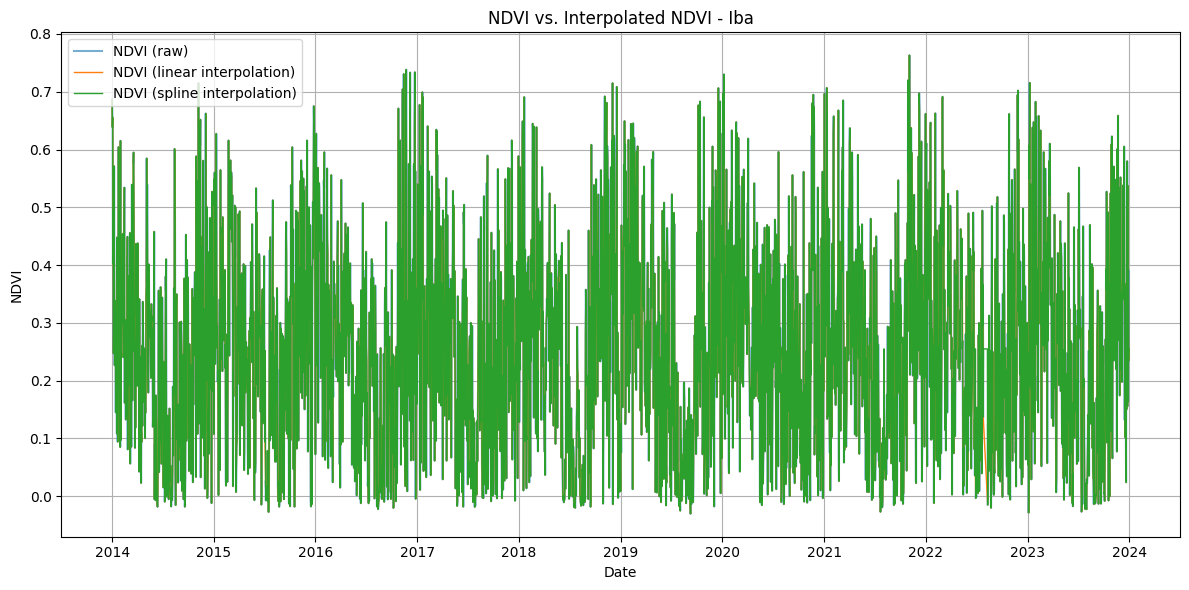

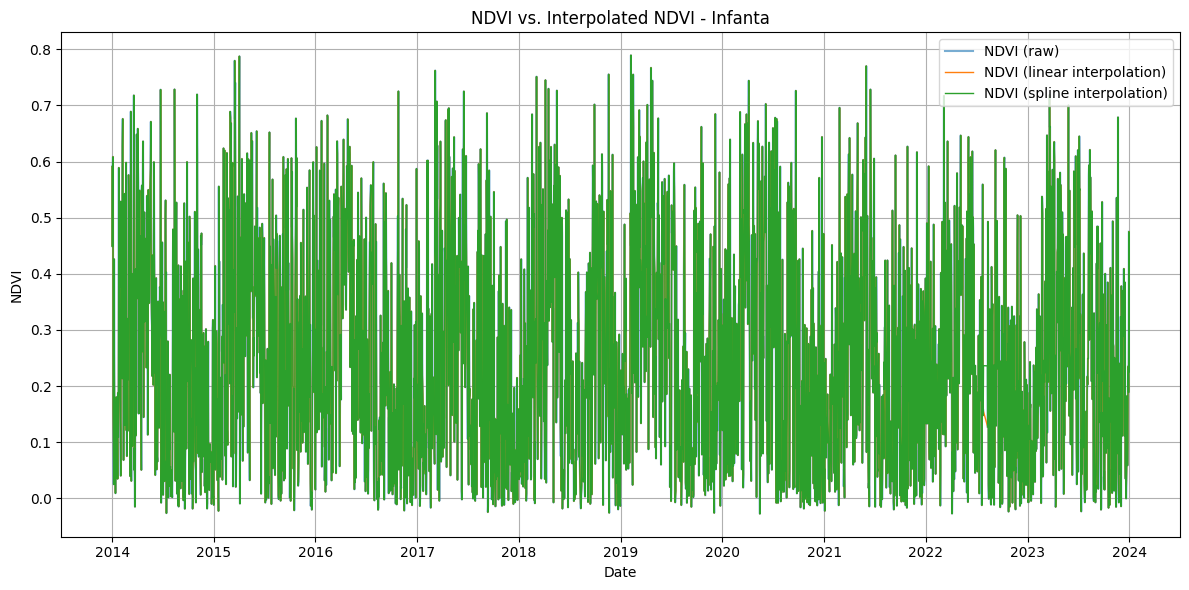

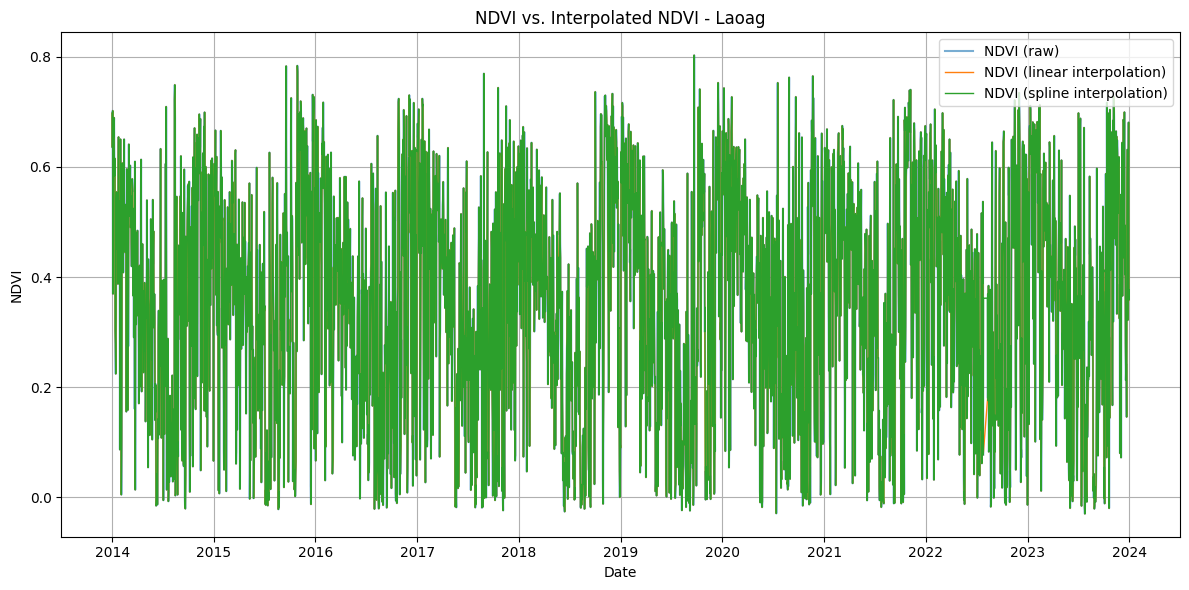

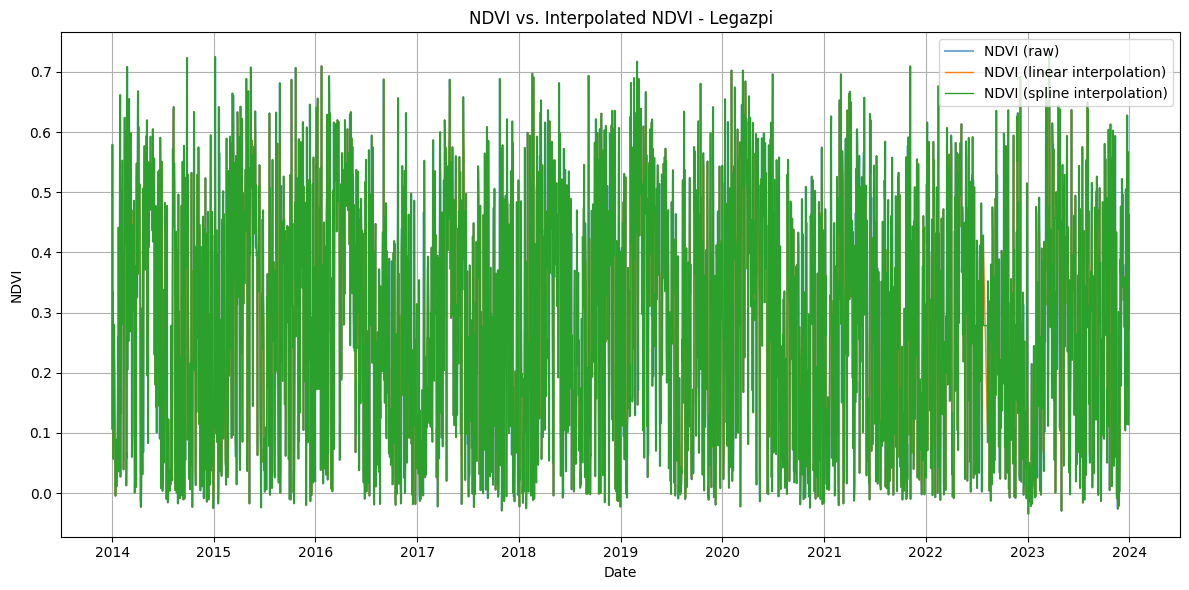

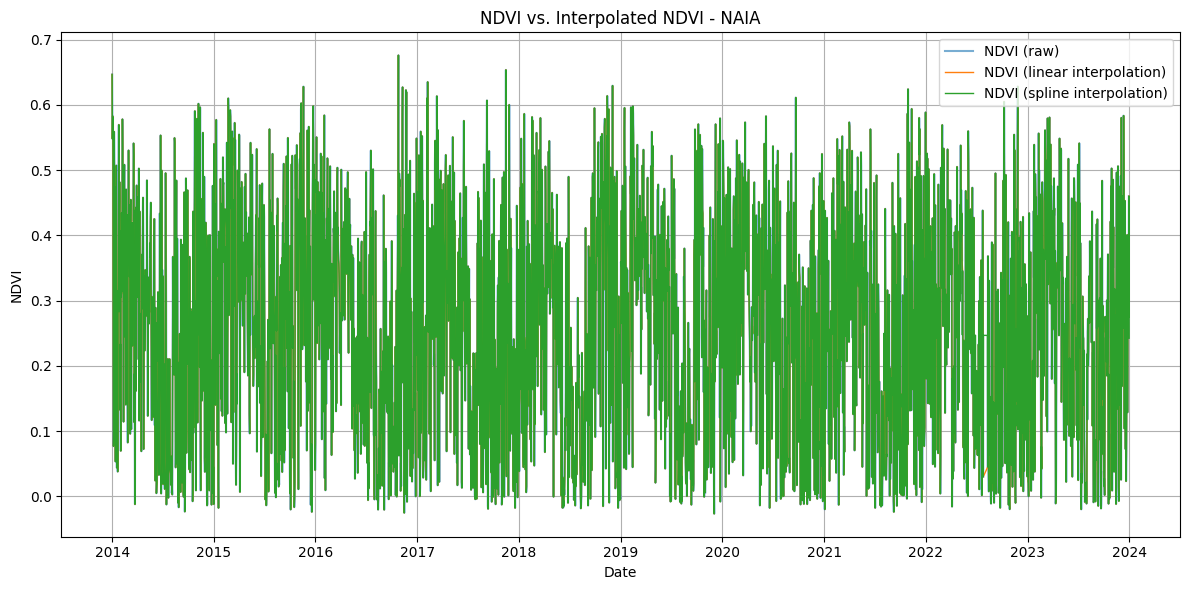

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDVI_original, NDVI_linear, NDVI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["NDVI_original"], label="NDVI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDVI_linear"], label="NDVI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDVI_spline"], label="NDVI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.title(f"NDVI vs. Interpolated NDVI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Iba", "Infanta", "Laoag", "Legazpi", "NAIA"]
for station in station_names:
    csv_file = f"{station}_NDVI.csv"
    plot_values(csv_file, station)

## NDBI

In [1]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [2]:
cloud_project = 'heat-index-472312'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Iba": ee.Geometry.Point([119.965661, 15.328408]).buffer(50000), # Longitude, Latitude
    "Infanta": ee.Geometry.Point([121.6490333, 14.74663611]).buffer(50000),
    "Laoag": ee.Geometry.Point([120.534723, 18.183016]).buffer(50000),
    "Legazpi": ee.Geometry.Point([123.728605, 13.150937]).buffer(50000),
    "NAIA": ee.Geometry.Point(([121.004751, 14.5047])).buffer(50000)
}

start_date = "2014-01-01"
end_date   = "2024-01-01"

In [3]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B5", "B6"])  # B05 = NIR, B06 = SWIR1
                         .multiply(0.0001)           # scale factor
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B8A", "B11"])  # B8A = NIR, B11 = SWIR1
                         .multiply(0.0001)
                         .rename(["B5", "B6"])     # rename to match Landsat
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

    # Compute NDBI = (SWIR - NIR) / (SWIR + NIR)
    def add_ndbi(img):
        ndbi = img.expression(
            "(SWIR - NIR) / (SWIR + NIR)",
            {"SWIR": img.select("B6"), "NIR": img.select("B5")}
        ).rename("NDBI")
        return img.addBands(ndbi).select("NDBI")

    return merged.map(add_ndbi)

In [4]:
def process_station(station_name, geometry, start_date, end_date):
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDBI for {station_name}...")

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original values
    g["NDBI_original"] = g["NDBI"]

    # Interpolate missing values only (keeping original intact)
    g["NDBI_linear"] = g["NDBI"].interpolate("linear", limit_direction="both")
    g["NDBI_spline"] = g["NDBI"].interpolate("spline", order=3, limit_direction="both")

    # Save to CSV: include original, interpolated, and smooth
    out_file = f"{station_name}_NDBI.csv"
    g[["date", "NDBI_original", "NDBI_linear", "NDBI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [5]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDBI for Iba...
Saved Iba_NDBI.csv (3653 rows)
Processing NDBI for Infanta...
Saved Infanta_NDBI.csv (3653 rows)
Processing NDBI for Laoag...
Saved Laoag_NDBI.csv (3653 rows)
Processing NDBI for Legazpi...
Saved Legazpi_NDBI.csv (3653 rows)
Processing NDBI for NAIA...
Saved NAIA_NDBI.csv (3653 rows)


In [6]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Iba:


date  NDBI  NDBI_original  NDBI_linear  NDBI_spline
0 2014-01-01   NaN            NaN    -0.271651    -0.086863
1 2014-01-02   NaN            NaN    -0.271651    -0.086948
2 2014-01-03   NaN            NaN    -0.271651    -0.087033
3 2014-01-04   NaN            NaN    -0.271651    -0.087119
4 2014-01-05   NaN            NaN    -0.271651    -0.087204

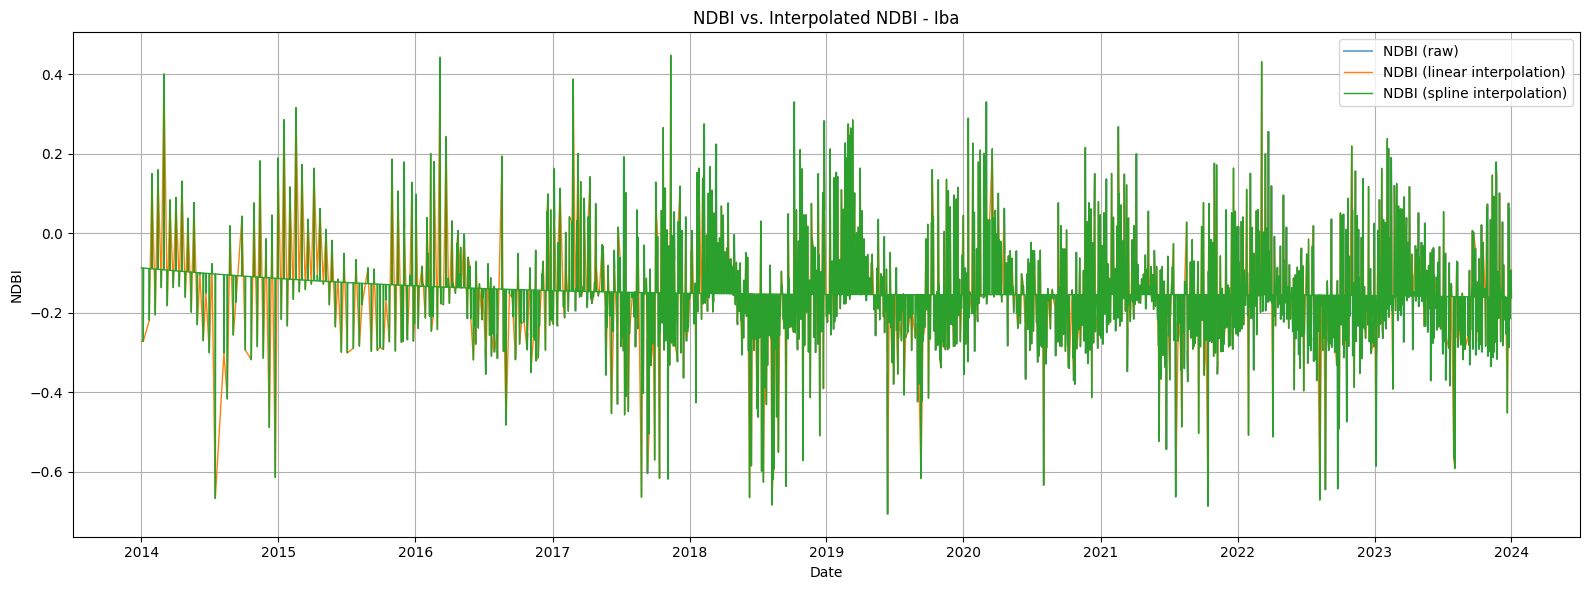

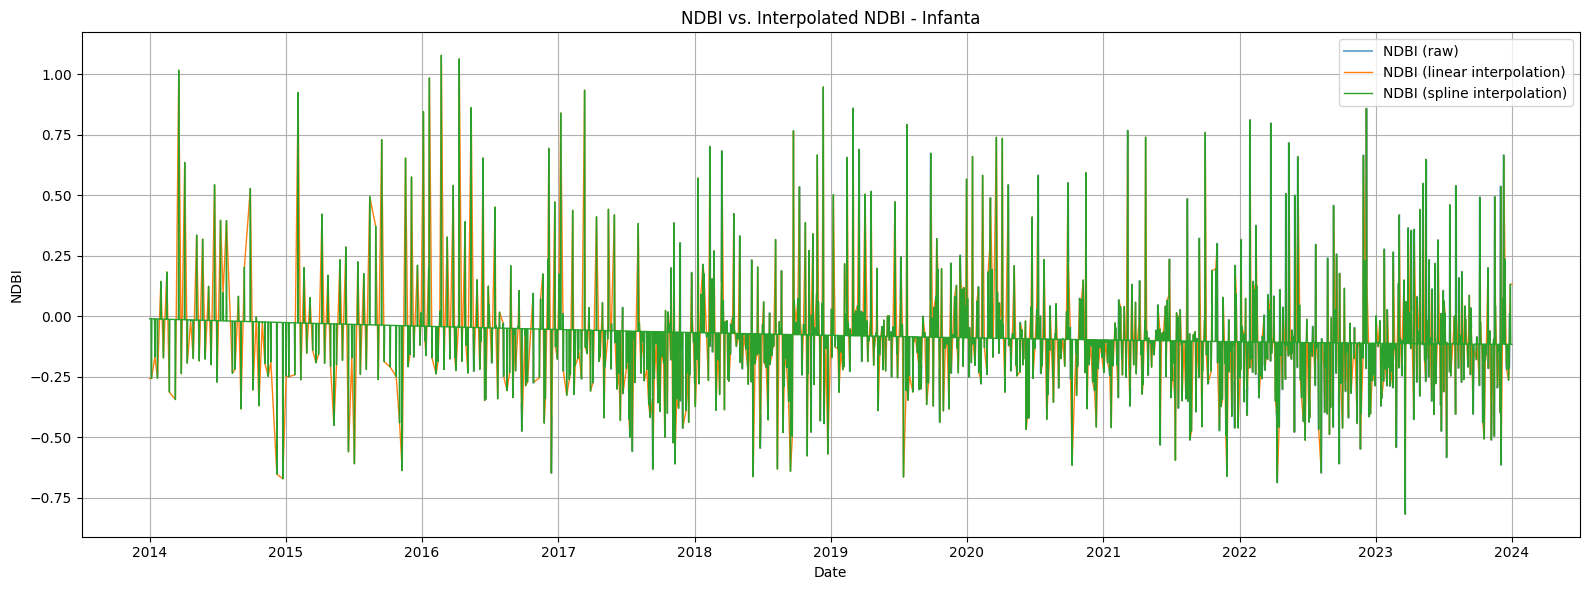

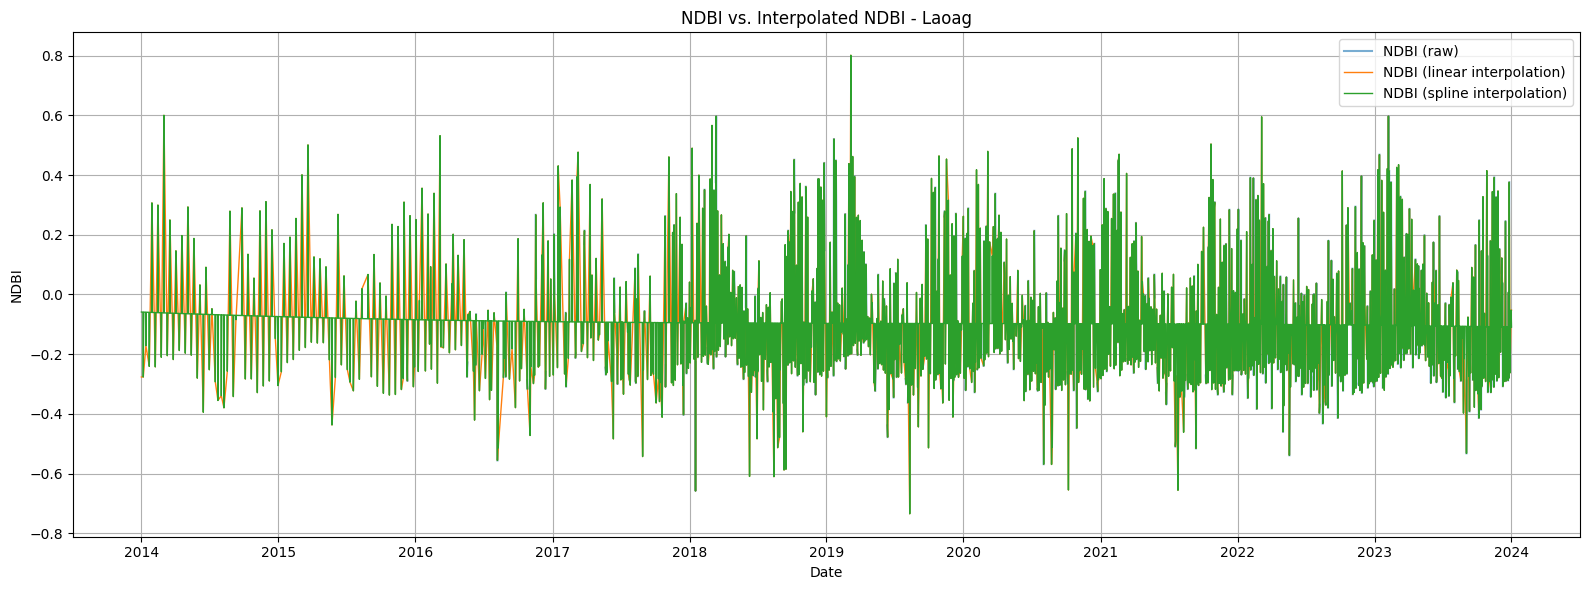

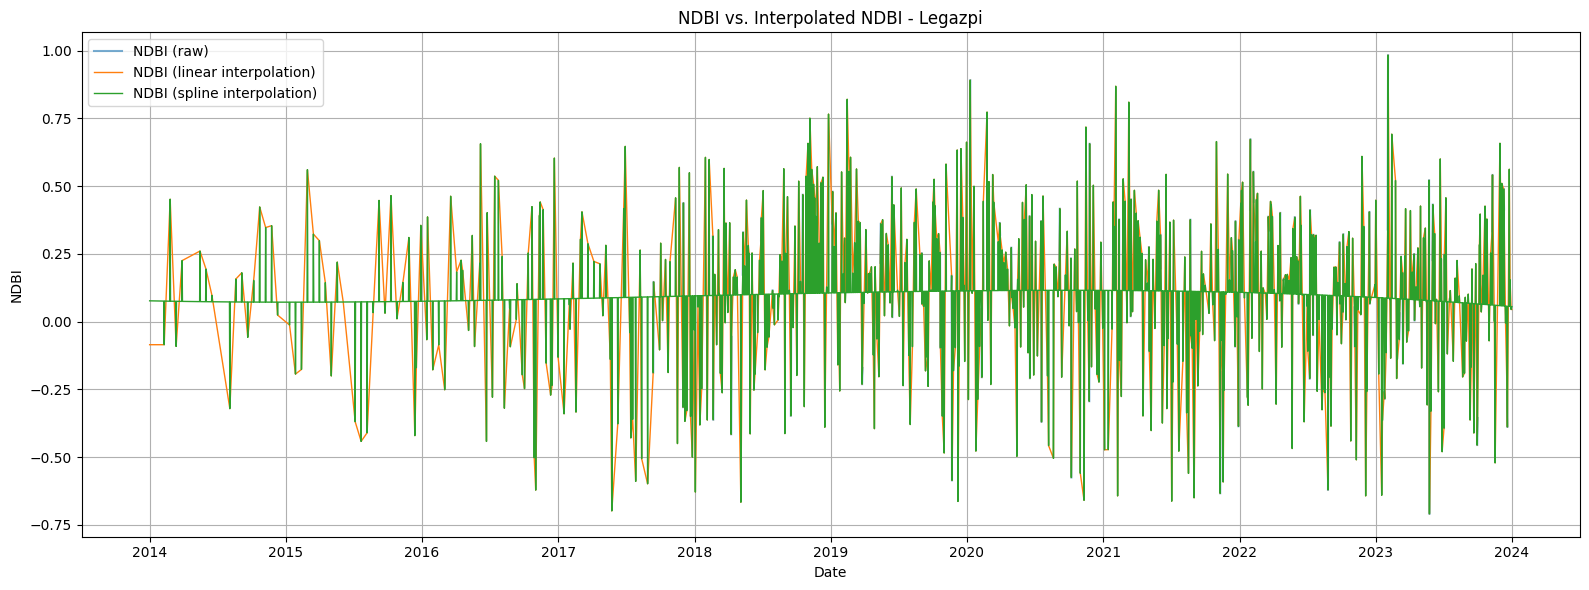

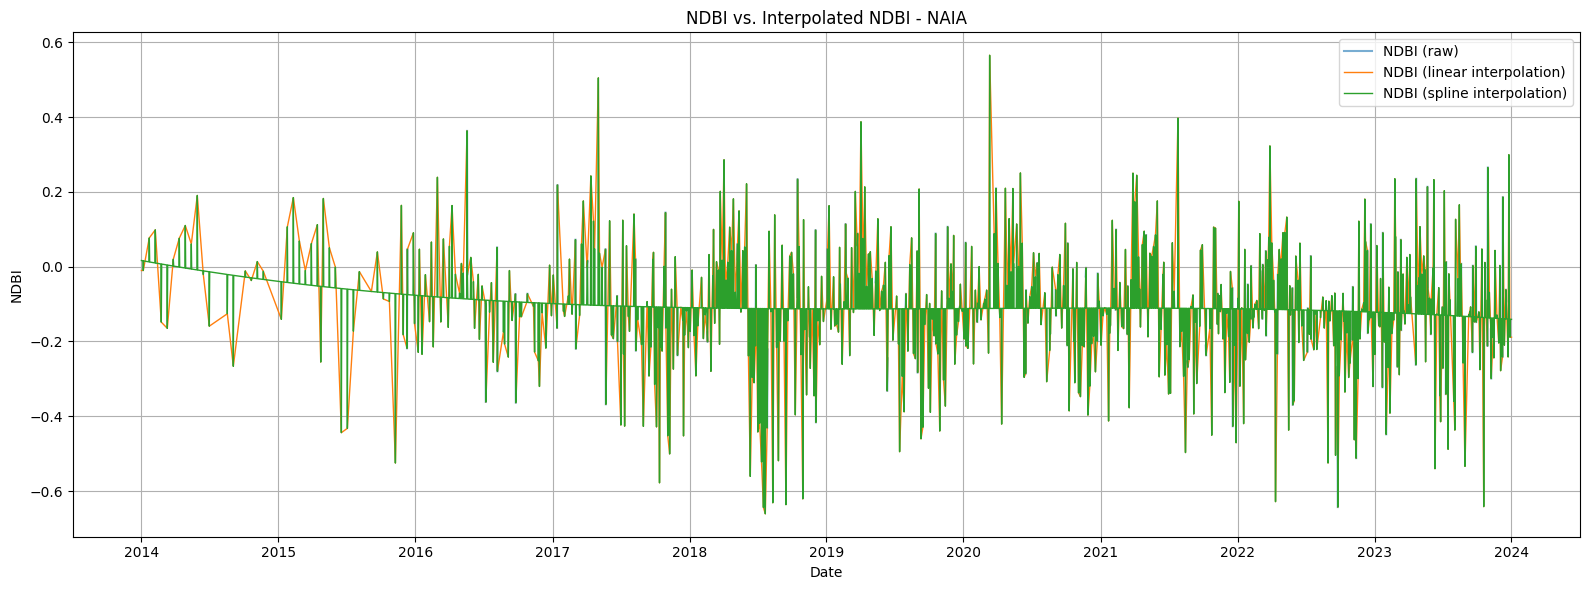

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBI_original"], label="NDBI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBI_linear"], label="NDBI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBI_spline"], label="NDBI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.title(f"NDBI vs. Interpolated NDBI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Iba", "Infanta", "Laoag", "Legazpi", "NAIA"]
for station in station_names:
    csv_file = f"{station}_NDBI.csv"
    plot_values(csv_file, station)

## ALBEDO

In [2]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [3]:
# Authenticate and initialize Earth Engine
cloud_project = 'heat-index-472312'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Iba": ee.Geometry.Point([119.965661, 15.328408]).buffer(25000),
    "Infanta": ee.Geometry.Point([121.6490333, 14.74663611]).buffer(25000),
    "Laoag": ee.Geometry.Point([120.534723, 18.183016]).buffer(25000),
    "Legazpi": ee.Geometry.Point([123.728605, 13.150937]).buffer(25000),
    "NAIA": ee.Geometry.Point([121.004751, 14.5047]).buffer(25000)
}

start_date = "2014-01-01"   # MODIS MCD43 start
end_date   = "2024-01-01"

In [4]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract daily Albedo time series from HLS (HLSL30 for Landsat, HLSS30 for Sentinel).
    Applies interpolation and saves to CSV.
    """

    print(f"Processing Albedo for {station_name}...")

    # Landsat (HLSL30)
    hlsl = ee.ImageCollection("NASA/HLS/HLSL30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def landsat_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B5")
        swir1 = img.select("B6")
        swir2 = img.select("B7")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).divide(1.016).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlsl_features = hlsl.map(landsat_albedo)

    # Sentinel (HLSS30)
    hlss = ee.ImageCollection("NASA/HLS/HLSS30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def sentinel_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B8")
        swir1 = img.select("B11")
        swir2 = img.select("B12")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlss_features = hlss.map(sentinel_albedo)

    # Merge Landsat + Sentinel results
    features = hlsl_features.merge(hlss_features)

    # Convert to pandas
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No data for {station_name}")
        return None

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Keep original values
    df = df.rename(columns={"Albedo": "Albedo_original"})

    # Reindex to daily frequency
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    df = df.set_index("date").reindex(full_range)
    df.index.name = "date"
    df = df.reset_index()

    # Interpolation
    df["Albedo_linear"] = df["Albedo_original"].interpolate(method="linear", limit_direction="both")
    df["Albedo_spline"] = df["Albedo_original"].interpolate(method="spline", order=2, limit_direction="both")

    # Metadata
    df["station"] = station_name

    # Save
    filename = f"{station_name}_Albedo.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {df.shape[0]} rows")

    return df

In [5]:
all_dfs = {}
for station, geom in stations.items():
     all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing Albedo for Iba...
Saved Iba_Albedo.csv with 3653 rows
Processing Albedo for Infanta...
Saved Infanta_Albedo.csv with 3653 rows
Processing Albedo for Laoag...
Saved Laoag_Albedo.csv with 3653 rows
Processing Albedo for Legazpi...
Saved Legazpi_Albedo.csv with 3653 rows
Processing Albedo for NAIA...
Saved NAIA_Albedo.csv with 3653 rows


In [6]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Iba:


date  Albedo_original  Albedo_linear  Albedo_spline station
0 2014-01-01              NaN       0.141337       0.195664     Iba
1 2014-01-02              NaN       0.141337       0.195686     Iba
2 2014-01-03              NaN       0.141337       0.195708     Iba
3 2014-01-04              NaN       0.141337       0.195730     Iba
4 2014-01-05              NaN       0.141337       0.195752     Iba

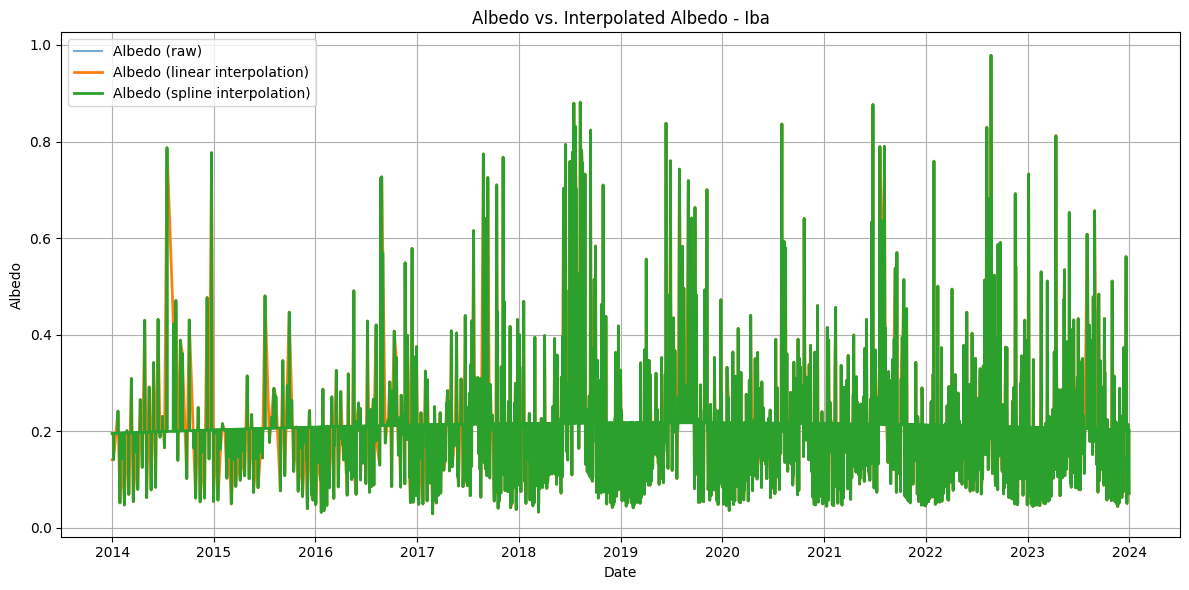

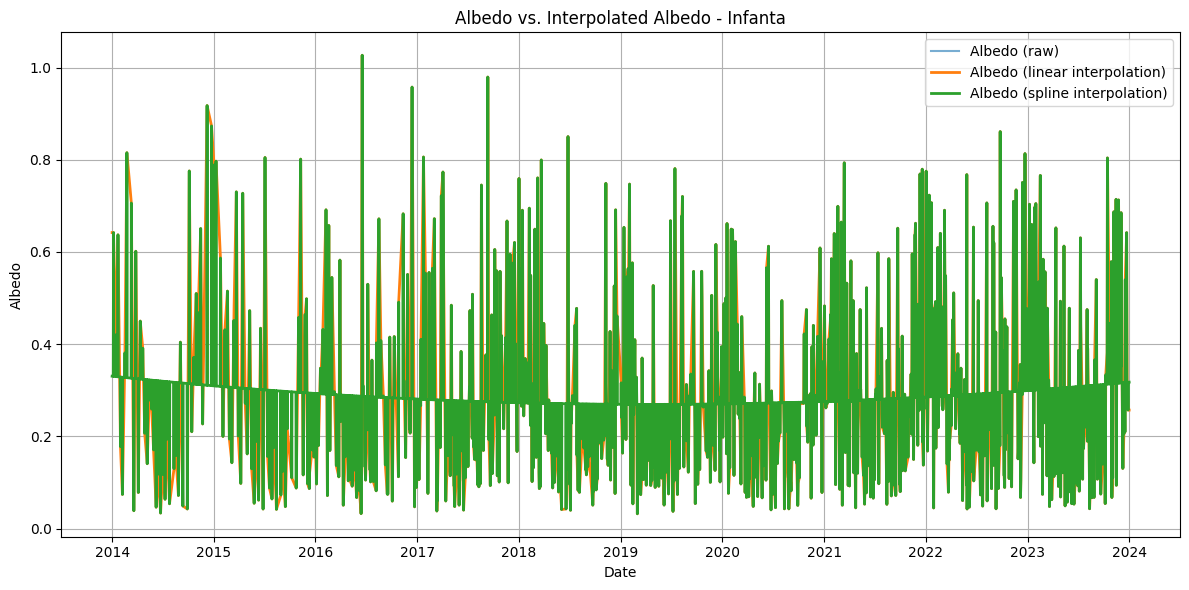

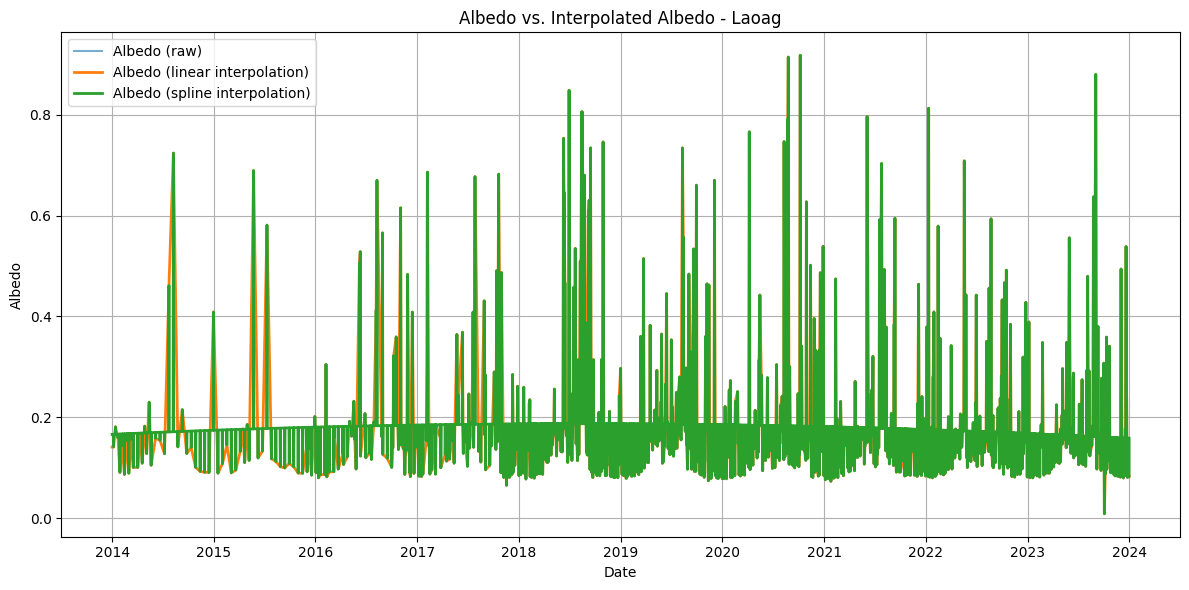

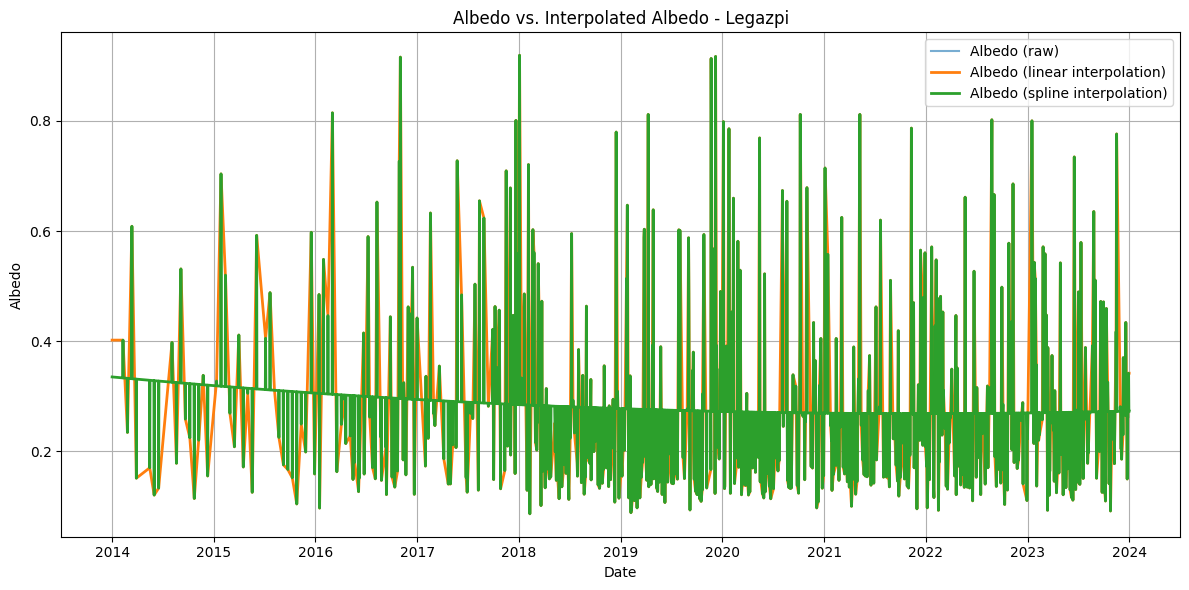

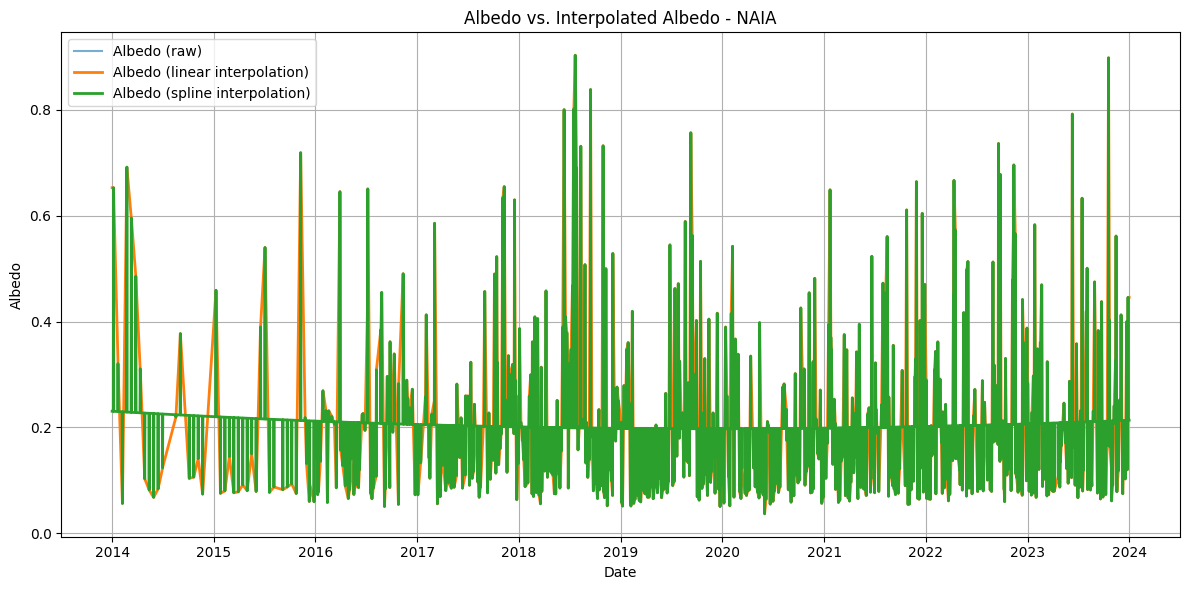

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Albedo_original"], label="Albedo (raw)", alpha=0.6)
    plt.plot(df["date"], df["Albedo_linear"], label="Albedo (linear interpolation)", linewidth=2)
    plt.plot(df["date"], df["Albedo_spline"], label="Albedo (spline interpolation)", linewidth=2)


    plt.xlabel("Date")
    plt.ylabel("Albedo")
    plt.title(f"Albedo vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Iba", "Infanta", "Laoag", "Legazpi", "NAIA"]
for station in station_names:
    csv_file = f"{station}_Albedo.csv"
    plot_values(csv_file, station)

## NDBaI


In [1]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [2]:
# Authenticate and initialize Earth Engine
cloud_project = 'heat-index-472312'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Iba": ee.Geometry.Point([119.965661, 15.328408]).buffer(25000),
    "Infanta": ee.Geometry.Point([121.6490333, 14.74663611]).buffer(25000),
    "Laoag": ee.Geometry.Point([120.534723, 18.183016]).buffer(25000),
    "Legazpi": ee.Geometry.Point([123.728605, 13.150937]).buffer(25000),
    "NAIA": ee.Geometry.Point([121.004751, 14.5047]).buffer(25000)
}

start_date = "2014-01-01"   # MODIS MCD43 start
end_date   = "2024-01-01"

In [3]:
def get_hls_collection(region, start_date, end_date):
    """
    Get HLS Landsat (HLSL30) collection and compute NDBaI.
    NDBaI = (SWIR - TIR) / (SWIR + TIR)
    Based on Zha et al. (2003), Xu (2008).
    """

    # Landsat-based HLS (HLSL30)
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img
             # Select relevant bands
             .select(["B5", "B6"], ["SWIR", "TIR"])  # SWIR1, Thermal IR
             # Apply scale factors
             .multiply(0.0001)
             .copyProperties(img, img.propertyNames()))
    )

    # Compute NDBaI
    def add_ndbai(img):
        ndbai = img.expression(
            "(SWIR - TIR) / (SWIR + TIR)",
            {
                "SWIR": img.select("SWIR"),
                "TIR": img.select("TIR")
            }
        ).rename("NDBaI")
        return img.addBands(ndbai).select("NDBaI")

    return hls_landsat.map(add_ndbai)

In [4]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Process HLS Landsat (HLSL30) collection to compute NDBaI time series,
    interpolate missing values, and export to CSV.
    """
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDBaI for {station_name}...")

    # Extract mean NDBaI for each image
    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBaI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBaI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to strict daily range
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original values
    g["NDBaI_original"] = g["NDBaI"]

    # Interpolation (fill missing only, originals remain intact)
    g["NDBaI_linear"] = g["NDBaI"].interpolate(
        method="linear", limit_direction="both"
    )
    g["NDBaI_spline"] = g["NDBaI"].interpolate(
        method="spline", order=3, limit_direction="both"
    )

    # Save to CSV
    out_file = f"{station_name}_NDBaI.csv"
    g[["date", "NDBaI_original", "NDBaI_linear", "NDBaI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [5]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDBaI for Iba...
Saved Iba_NDBaI.csv (3653 rows)
Processing NDBaI for Infanta...
Saved Infanta_NDBaI.csv (3653 rows)
Processing NDBaI for Laoag...
Saved Laoag_NDBaI.csv (3653 rows)
Processing NDBaI for Legazpi...
Saved Legazpi_NDBaI.csv (3653 rows)
Processing NDBaI for NAIA...
Saved NAIA_NDBaI.csv (3653 rows)


In [6]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Iba:


date  NDBaI  NDBaI_original  NDBaI_linear  NDBaI_spline
0 2014-01-01    NaN             NaN      0.207466     -0.051146
1 2014-01-02    NaN             NaN      0.207466     -0.051096
2 2014-01-03    NaN             NaN      0.207466     -0.051046
3 2014-01-04    NaN             NaN      0.207466     -0.050995
4 2014-01-05    NaN             NaN      0.207466     -0.050945

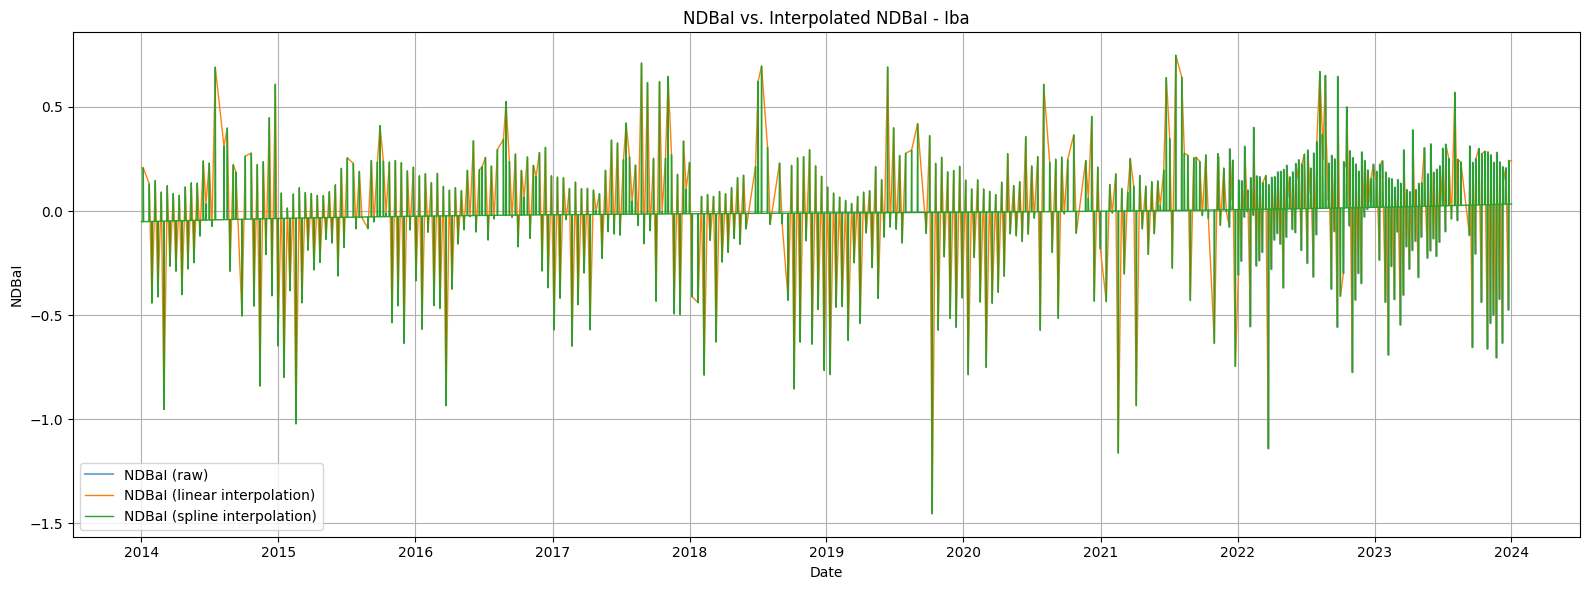

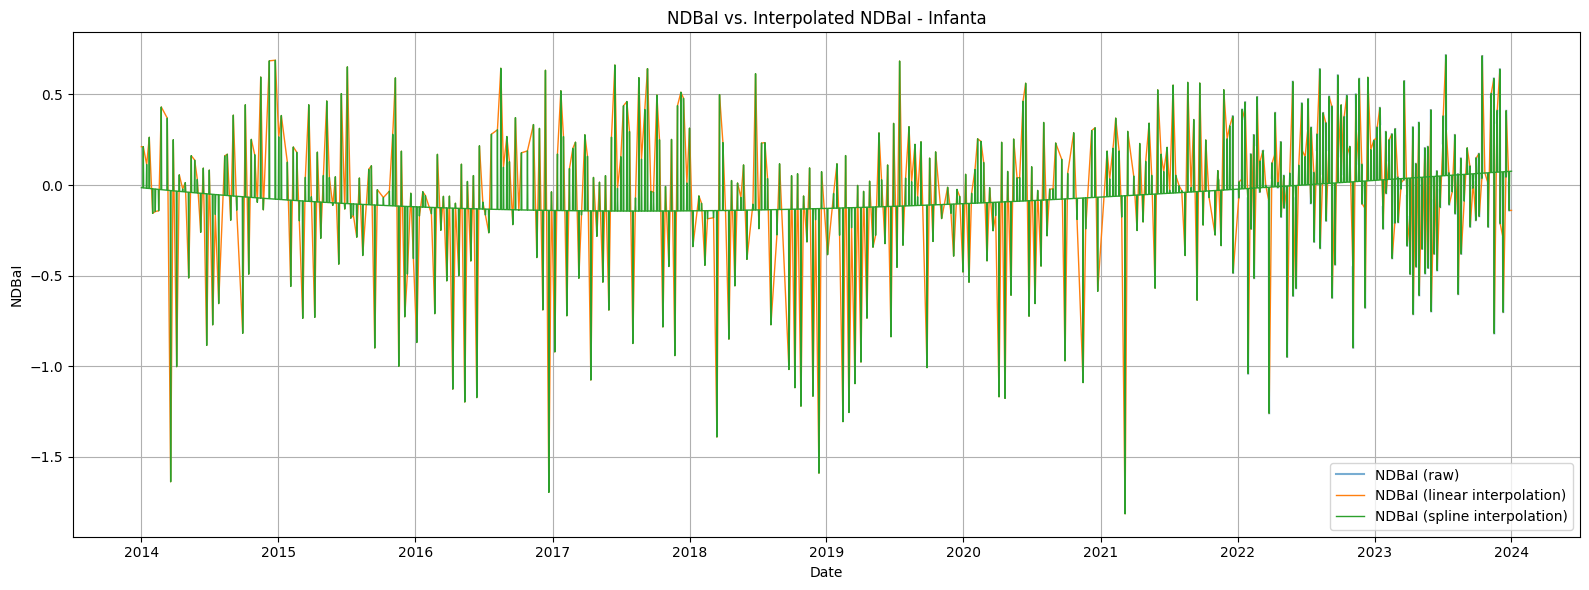

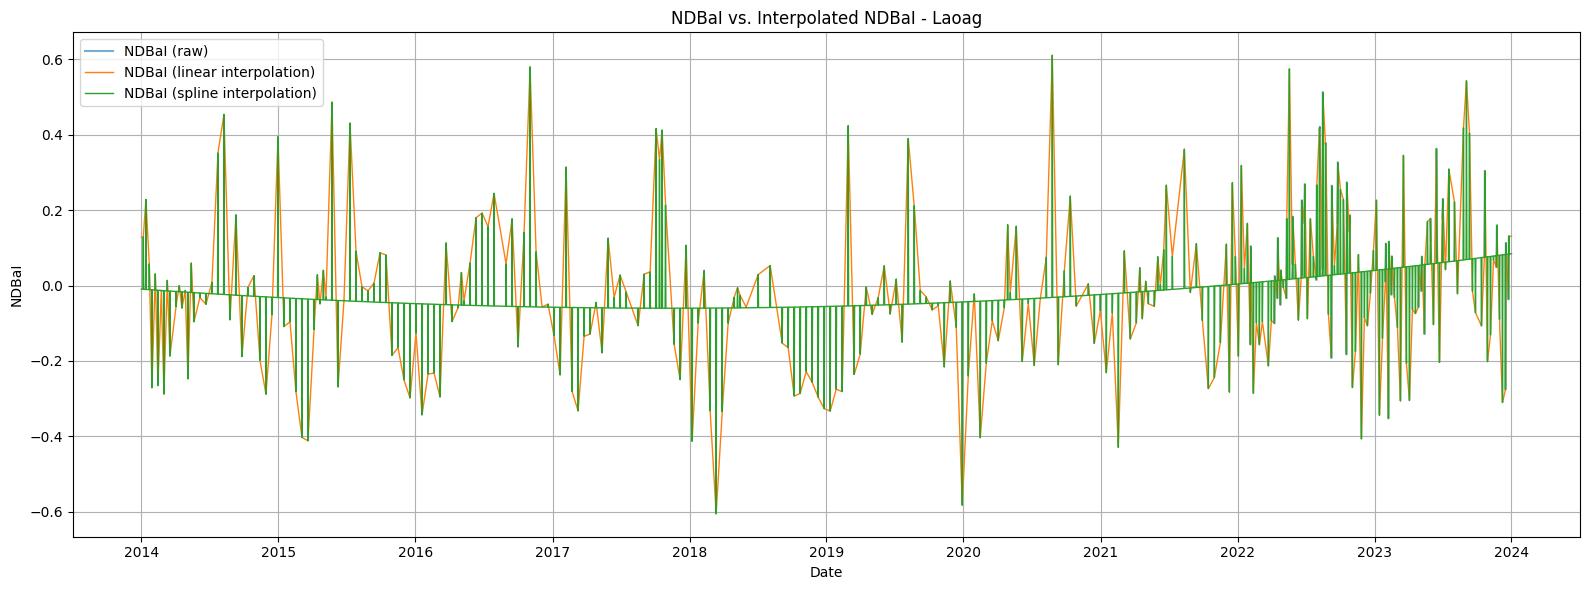

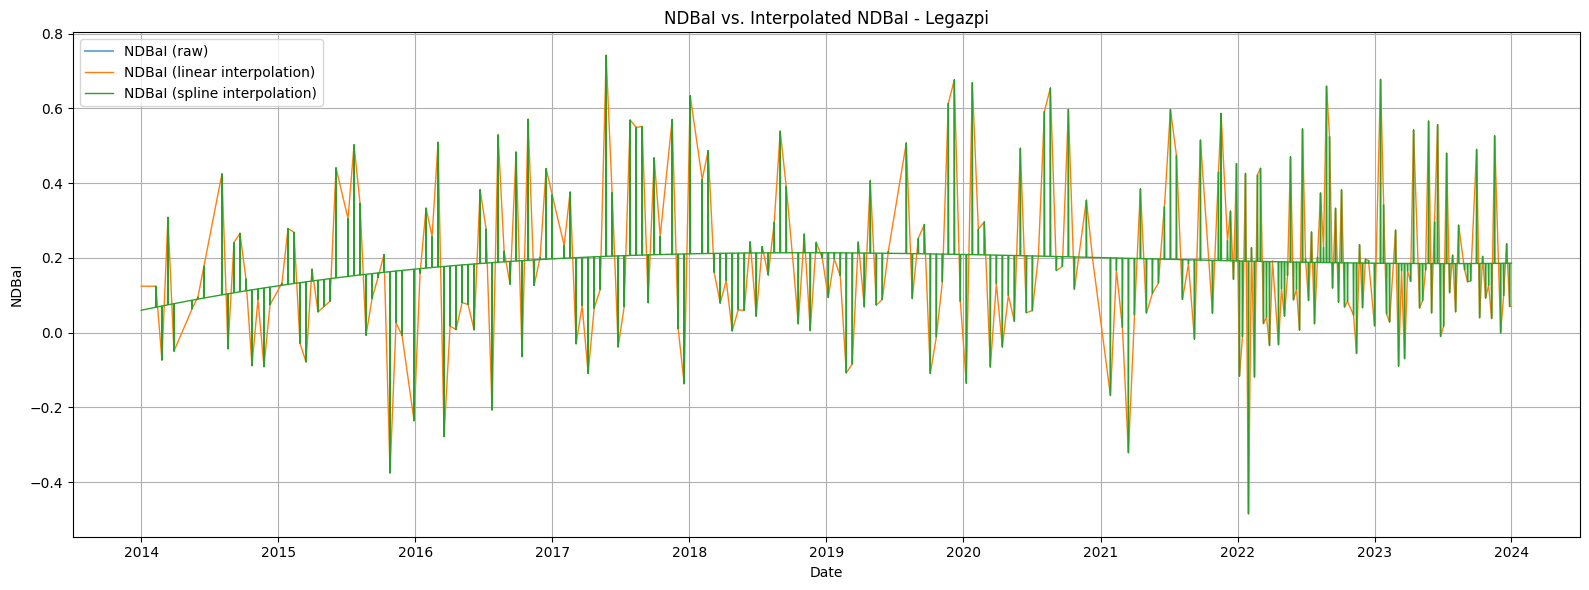

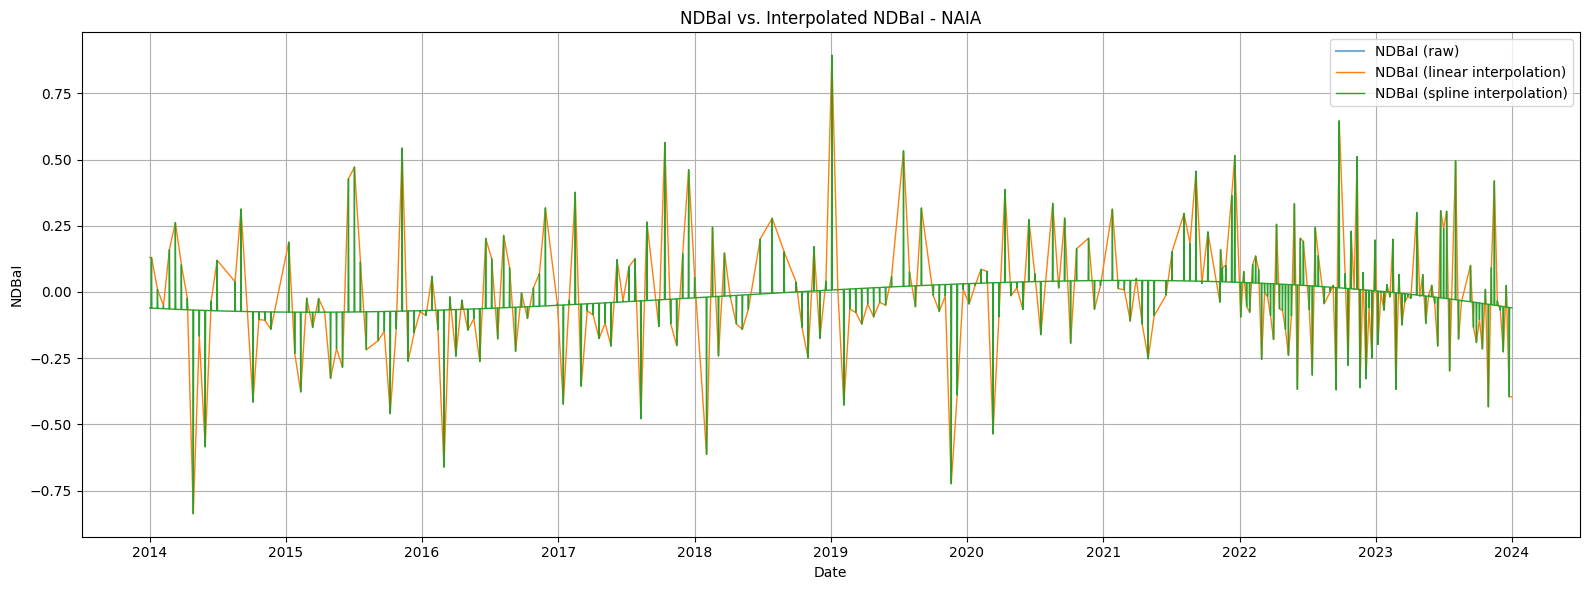

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBaI_original"], label="NDBaI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBaI_linear"], label="NDBaI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBaI_spline"], label="NDBaI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDBaI")
    plt.title(f"NDBaI vs. Interpolated NDBaI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Iba", "Infanta", "Laoag", "Legazpi", "NAIA"]
for station in station_names:
    csv_file = f"{station}_NDBaI.csv"
    plot_values(csv_file, station)

## NDWI

In [8]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [9]:
# Authenticate and initialize Earth Engine
cloud_project = 'heat-index-472312'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Iba": ee.Geometry.Point([119.965661, 15.328408]).buffer(25000),
    "Infanta": ee.Geometry.Point([121.6490333, 14.74663611]).buffer(25000),
    "Laoag": ee.Geometry.Point([120.534723, 18.183016]).buffer(25000),
    "Legazpi": ee.Geometry.Point([123.728605, 13.150937]).buffer(25000),
    "NAIA": ee.Geometry.Point([121.004751, 14.5047]).buffer(25000)
}

start_date = "2014-01-01"   # MODIS MCD43 start
end_date   = "2024-01-01"

In [10]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B3", "B5"])  # Green = B3, NIR = B5
                         .multiply(0.0001)
                         .rename(["GREEN", "NIR"])
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B3", "B8"])  # Green = B3, NIR = B8
                         .multiply(0.0001)
                         .rename(["GREEN", "NIR"])
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

     # Compute NDWI
    def add_ndwi(img):
        ndwi = img.normalizedDifference(["GREEN", "NIR"]).rename("NDWI")
        return img.addBands(ndwi).select("NDWI")

    return merged.map(add_ndwi)

In [11]:
def process_station(station_name, geometry, start_date, end_date):
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDWI for {station_name}...")

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDWI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDWI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original
    g["NDWI_original"] = g["NDWI"]

    # Interpolate missing values
    g["NDWI_linear"] = g["NDWI"].interpolate("linear", limit_direction="both")
    g["NDWI_spline"] = g["NDWI"].interpolate("spline", order=3, limit_direction="both")

    # Save to CSV
    out_file = f"{station_name}_NDWI.csv"
    g[["date", "NDWI_original", "NDWI_linear", "NDWI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [12]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDWI for Iba...
Saved Iba_NDWI.csv (3653 rows)
Processing NDWI for Infanta...
Saved Infanta_NDWI.csv (3653 rows)
Processing NDWI for Laoag...
Saved Laoag_NDWI.csv (3653 rows)
Processing NDWI for Legazpi...
Saved Legazpi_NDWI.csv (3653 rows)
Processing NDWI for NAIA...
Saved NAIA_NDWI.csv (3653 rows)


In [13]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Iba:


date  NDWI  NDWI_original  NDWI_linear  NDWI_spline
0 2014-01-01   NaN            NaN    -0.633553    -0.227976
1 2014-01-02   NaN            NaN    -0.633553    -0.227995
2 2014-01-03   NaN            NaN    -0.633553    -0.228013
3 2014-01-04   NaN            NaN    -0.633553    -0.228031
4 2014-01-05   NaN            NaN    -0.633553    -0.228050

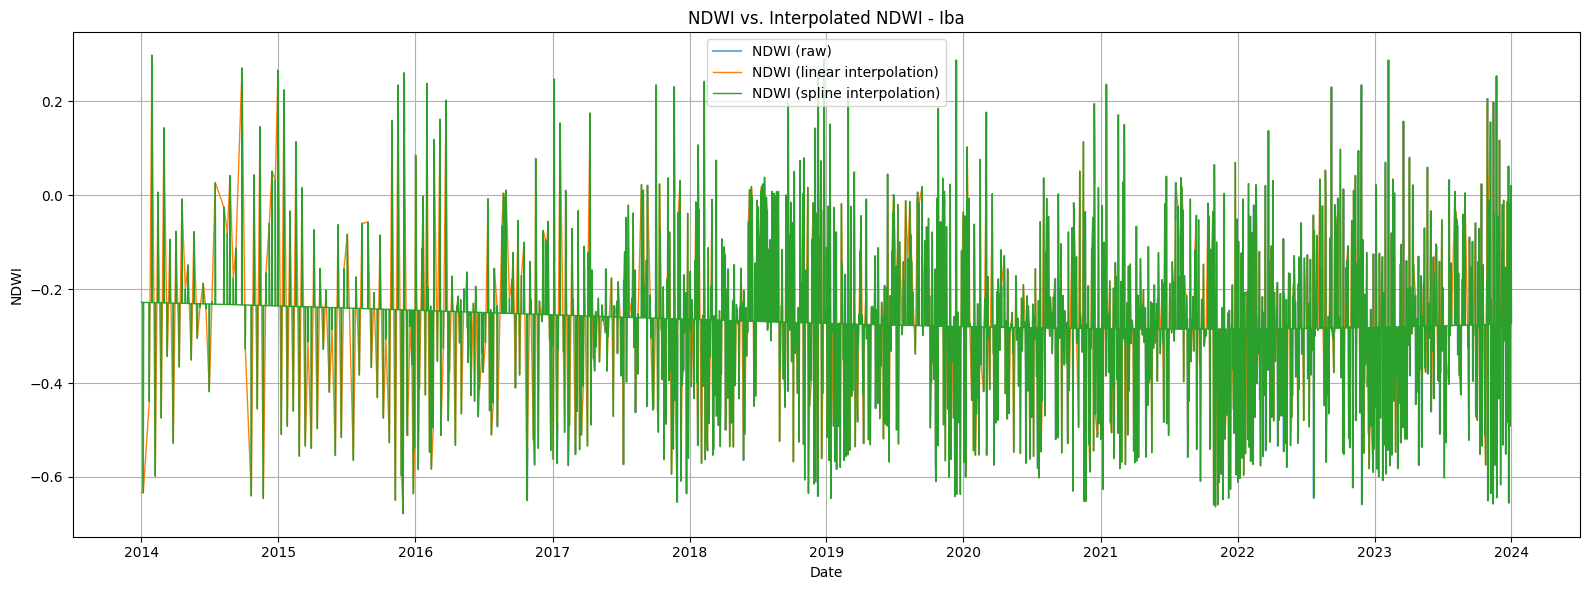

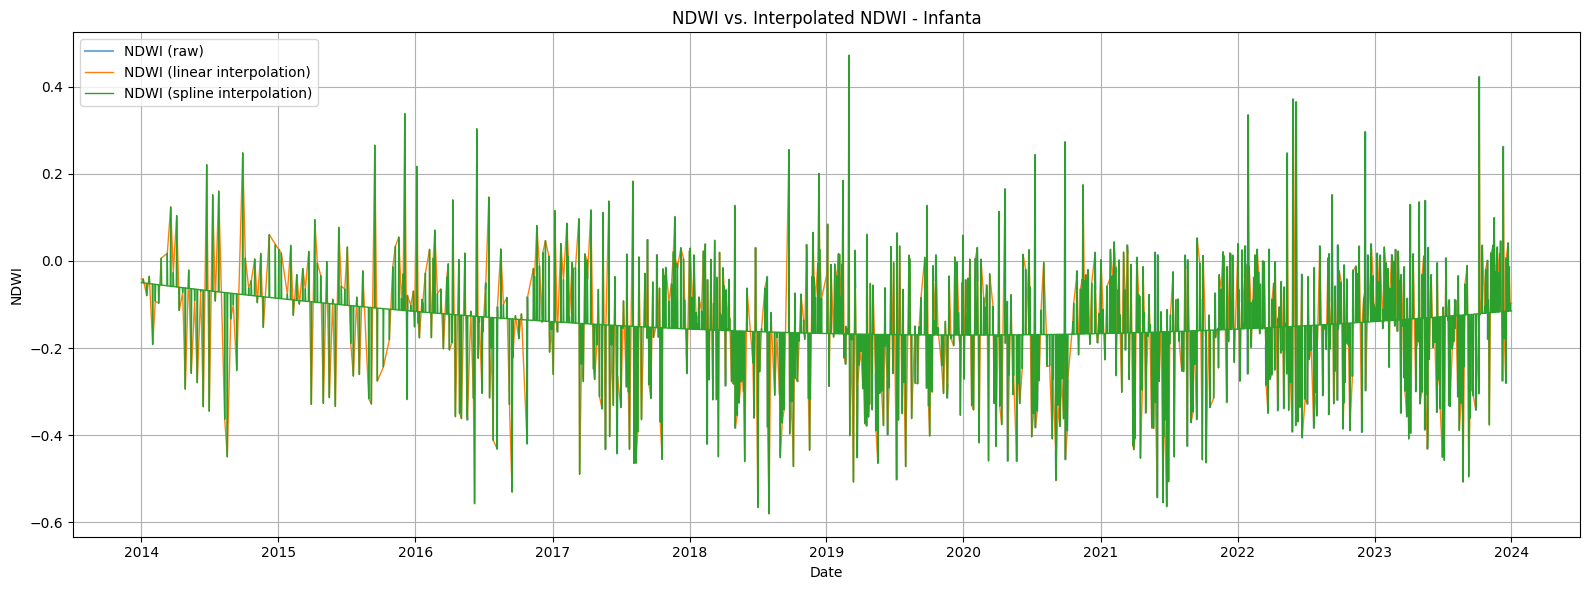

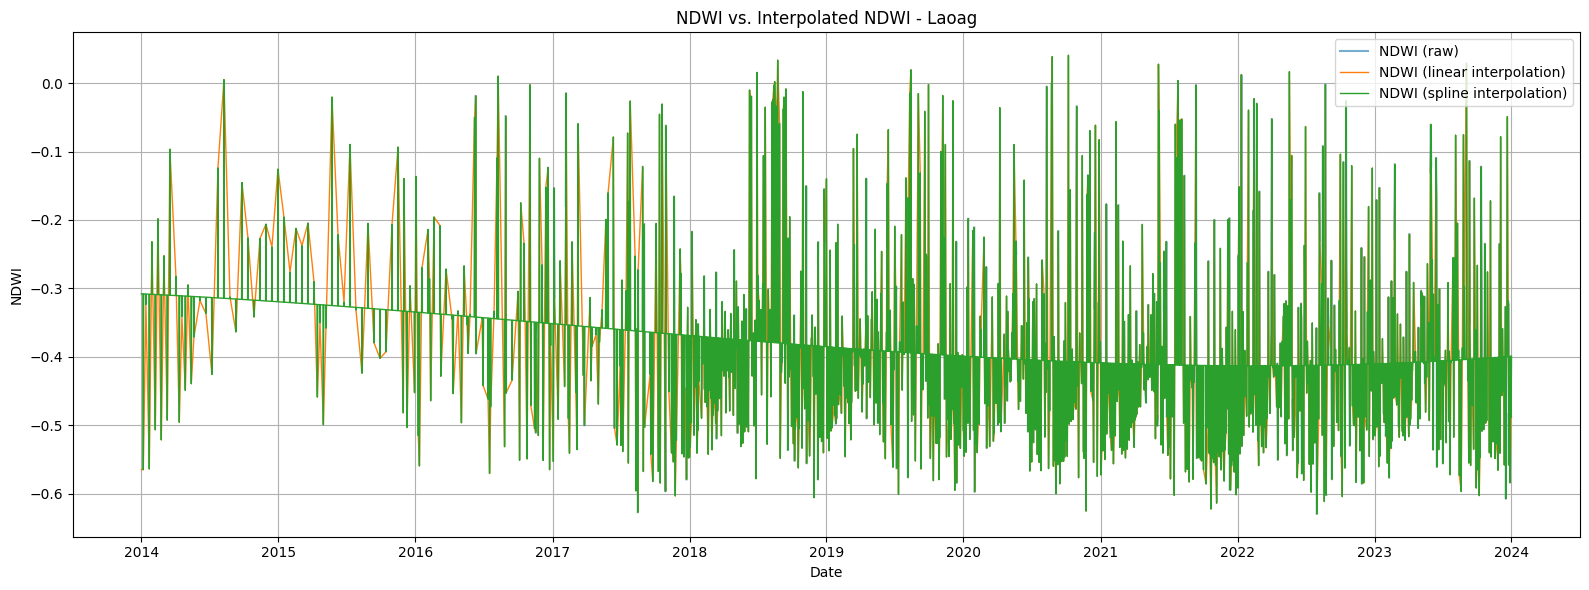

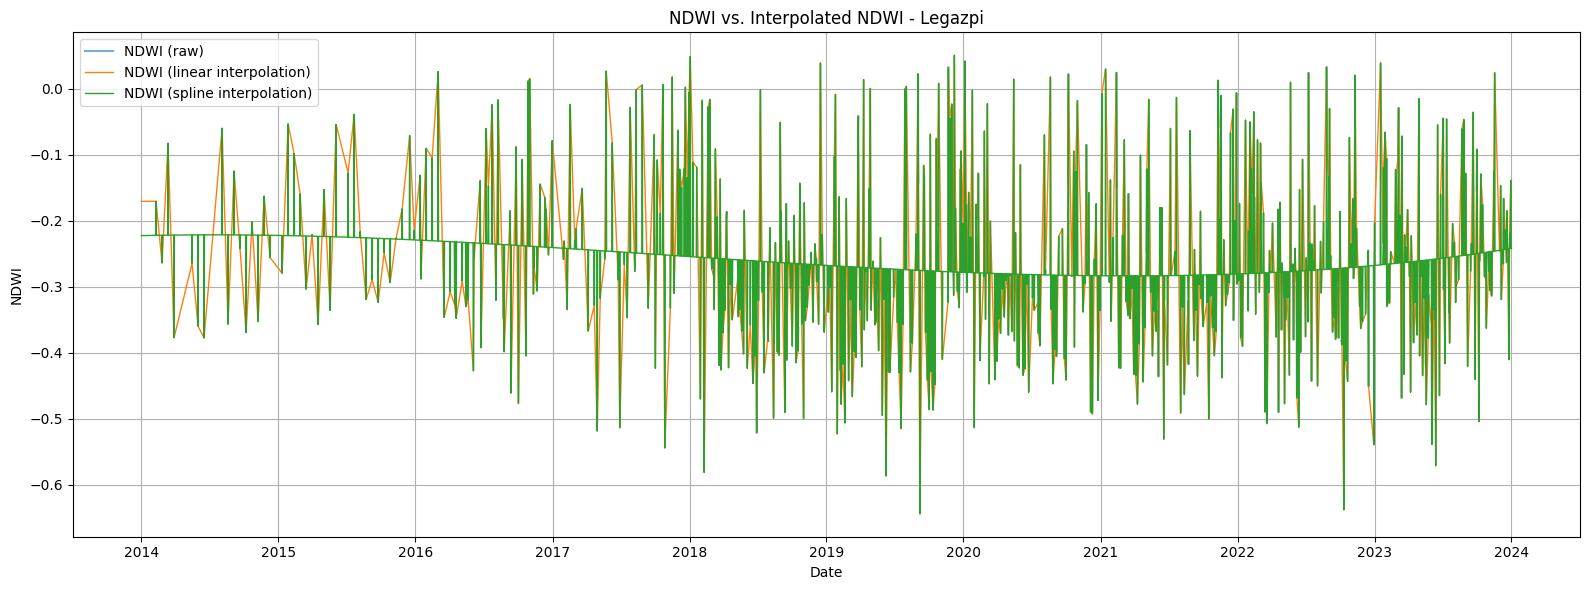

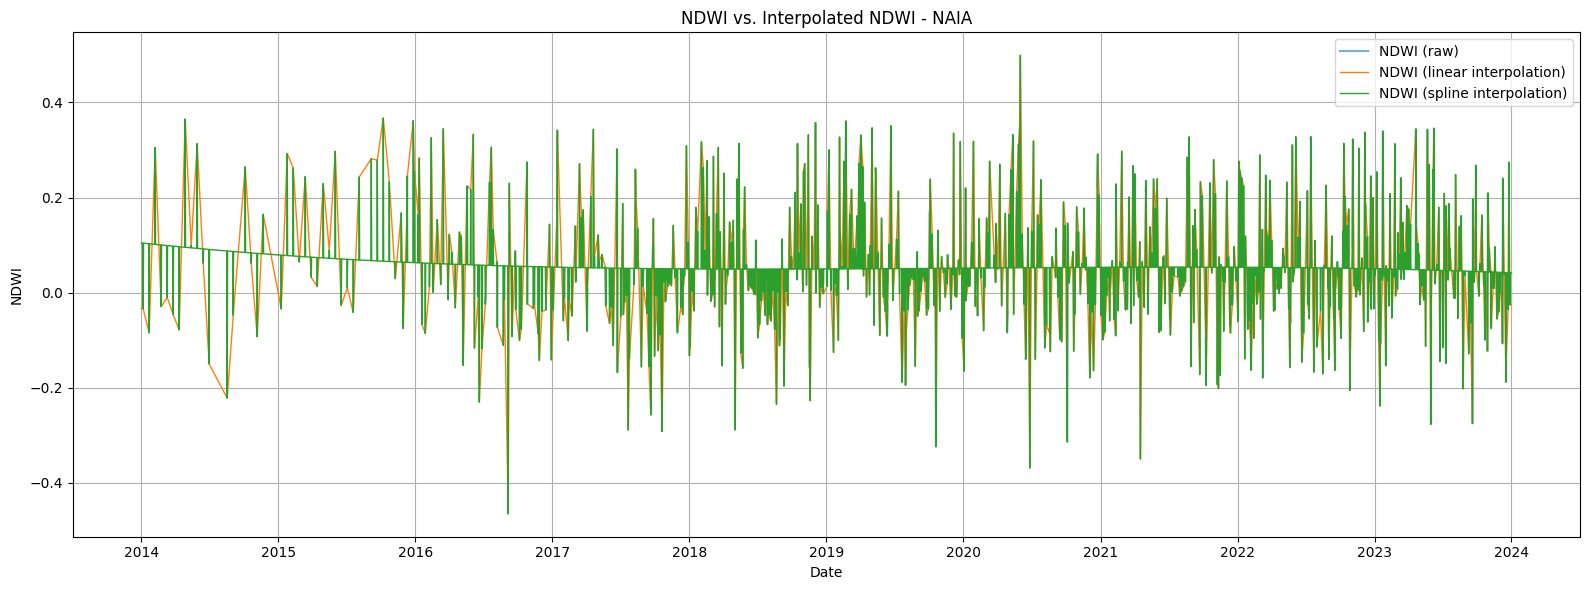

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDWI_original, NDWI_linear, NDWI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDWI_original"], label="NDWI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDWI_linear"], label="NDWI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDWI_spline"], label="NDWI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDWI")
    plt.title(f"NDWI vs. Interpolated NDWI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Iba", "Infanta", "Laoag", "Legazpi", "NAIA"]
for station in station_names:
    csv_file = f"{station}_NDWI.csv"
    plot_values(csv_file, station)